# Установка

In [ ]:
# Установим свежую версию TensorFlow для поддержки слоя `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow
!pip install datasets

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libcudnn8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 818.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.17.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Импорт

In [ ]:
# Логирование для отладки
import logging

# Замеры времени выполнения
import time

# Линейная алгебра
import numpy as np

from datasets import load_dataset

import pandas as pd

# Вывод графиков
import matplotlib.pyplot as plt

# Фреймворк Tensorflow
import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text as text
# Регулярные выражения
import re

# Файловая система
import pathlib

# Токенизатор
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

from sklearn.model_selection import train_test_split

# Отключим мешаюшие предупреждения
import warnings
warnings.filterwarnings("ignore")

# Предобработка данных

In [ ]:
dataset = load_dataset('Den4ikAI/russian_dialogues', split='train') # Скачивание датасета

df = pd.DataFrame(dataset) # Превращение в датафрей
df = df.dropna() # Очищаю от пустых ячеек
df = df.drop(columns=["relevance"]) # Убираю ненужный столбец

README.md:   0%|          | 0.00/951 [00:00<?, ?B/s]

dataset.jsonl:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2477321 [00:00<?, ? examples/s]

## Разбиваю данные

In [ ]:
question_train, question_test, answer_train, answer_test = train_test_split(df["question"].tolist(), df["answer"].tolist(), test_size=0.2, shuffle=True)

## Превращаю в dataset

In [ ]:
question_train, question_test, answer_train, answer_test = question_train[:40000], question_test[:10000], answer_train[:40000], answer_test[:10000]
train_dataset = tf.data.Dataset.from_tensor_slices((question_train, answer_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((question_test, answer_test))

## Вызываем примеры

In [ ]:
print('Размер обучающей выборки: ', len(train_dataset))
print('Размер валидационной выборки: ', len(validation_dataset))

Размер обучающей выборки:  40000
Размер валидационной выборки:  10000


In [ ]:
for pt_examples, en_examples in train_dataset.batch(3).take(1):
  print('Примеры вопросов:')
  print()
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('Примеры отвтов:')
  print()
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

Примеры вопросов:

никогда, только без
апелляционный суд одним заседанием рассматривает дело или может переносить?
почему у всех людей разные лица, в отличие от животных? есть ли такое у каких-то животных?

Примеры отвтов:

там холодно
если есть необходимость, то конечно заседание может быть отложено.
чабаны каждую овцу знают в лицо. т. е. в морду. а вы говорите в отличие


# Токенизация

## Создаем BERT токенизатор

### Создаем словари слов

In [ ]:
VOCAB_SIZE = 8000
# Параметры токенизатора (lower_case - приводим к нижнему регистру)
bert_tokenizer_params=dict(lower_case=True)

# Определяем токены, с которыми работает токенизатор
# [START] - начало строки
# [END]   - конец строки
# [UNK]   - неизвестное слово
# [PAD]   - используется для выравнивания длин всех предложений
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # Желаемый размер словаря
    vocab_size = VOCAB_SIZE,
    # Токены включаемые в словарь
    reserved_tokens=reserved_tokens,
    # Аргументы для `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Аргументы для `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={}, # не используем, но определяем чтобы не было ошибок
)

In [ ]:
# @title Вспомогательные лямбда функций
train_answer = train_dataset.map(lambda pt, en: en)
train_question = train_dataset.map(lambda pt, en: pt)

In [ ]:
%%time
question_vocab = bert_vocab.bert_vocab_from_dataset(
    train_question.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 2min 7s, sys: 630 ms, total: 2min 7s
Wall time: 2min 6s


In [ ]:
%%time
answer_vocab = bert_vocab.bert_vocab_from_dataset(
    train_answer.batch(1000).prefetch(2),
    **bert_vocab_args
)

CPU times: user 2min 31s, sys: 664 ms, total: 2min 32s
Wall time: 2min 31s


In [ ]:
# @title Фрагменты словаря
print("Словарь вопросов")
print(question_vocab[:10])
print(question_vocab[100:110])
print(question_vocab[1000:1010])
print(question_vocab[-10:])

print("\n\nСловарь ответов")
print(answer_vocab[:10])
print(answer_vocab[100:110])
print(answer_vocab[1000:1010])
print(answer_vocab[-10:])

Словарь вопросов
['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '-', '.', ':', ';']
['какие', 'бы', 'какои', 'нет', 'мне', 'будет', 'лучше', '##у', 'из', 'может']
['поити', 'права', 'сны', 'столько', 'стране', 'украина', 'язык', '##бои', '##нки', '##рии']
['##:', '##;', '##?', '##c', '##g', '##h', '##j', '##q', '##w', '##z']


Словарь ответов
['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '-', '.', ':', ';']
['просто', 'уже', 'же', '##у', 'бы', 'он', 'они', 'вот', 'надо', 'может']
['взгляд', 'вкусно', 'добро', 'живут', 'занимаюсь', 'каждому', 'новое', 'общем', 'права', 'прежде']
['##;', '##?', '##h', '##i', '##j', '##m', '##q', '##v', '##w', '##z']


In [ ]:
# @title Функция сохранения словаря в файлв
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
# Сохраняем файлы
write_vocab_file('question_vocab.txt', question_vocab)
write_vocab_file('answer_vocab.txt', answer_vocab)

# Проверка файлов
!ls *.txt

answer_vocab.txt  question_vocab.txt


In [ ]:
# @title Загружаем токенизаторы
question_tokenizer = text.BertTokenizer('question_vocab.txt', **bert_tokenizer_params)
answer_tokenizer = text.BertTokenizer('answer_vocab.txt', **bert_tokenizer_params)

In [ ]:
print('Отберем строки для примера:')
for pt_examples, en_examples in train_dataset.batch(3).take(1):
  for ex in en_examples:
    print(ex.numpy().decode('utf-8'))

Отберем строки для примера:
там холодно
если есть необходимость, то конечно заседание может быть отложено.
чабаны каждую овцу знают в лицо. т. е. в морду. а вы говорите в отличие


In [ ]:
# Токенизируем примеры и получаем тензор формы (batch, word, word-piece)
token_batch = answer_tokenizer.tokenize(en_examples)
# Объединяем оси word и word-piece и получаем тензор формы (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)

print('Токенизируем отобранные строки:')
for ex in token_batch.to_list():
  print(ex)

Токенизируем отобранные строки:
[114, 2469]
[75, 85, 2706, 5, 72, 132, 98, 835, 2747, 109, 119, 86, 414, 5458, 7]
[59, 84, 783, 210, 3664, 50, 200, 1114, 753, 39, 1365, 7, 54, 7, 42, 7, 39, 48, 642, 448, 7, 37, 110, 2193, 39, 3215]


In [ ]:
words = answer_tokenizer.detokenize(token_batch)
print('Проверим обратное преобразование:')

# Объединение полученного тензора в текст, объединяем пробелами
print(tf.strings.reduce_join(words, separator=' ', axis=-1))


Проверим обратное преобразование:
tf.Tensor(
[b'\xd1\x82\xd0\xb0\xd0\xbc \xd1\x85\xd0\xbe\xd0\xbb\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe'
 b'\xd0\xb5\xd1\x81\xd0\xbb\xd0\xb8 \xd0\xb5\xd1\x81\xd1\x82\xd1\x8c \xd0\xbd\xd0\xb5\xd0\xbe\xd0\xb1\xd1\x85\xd0\xbe\xd0\xb4\xd0\xb8\xd0\xbc\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c , \xd1\x82\xd0\xbe \xd0\xba\xd0\xbe\xd0\xbd\xd0\xb5\xd1\x87\xd0\xbd\xd0\xbe \xd0\xb7\xd0\xb0\xd1\x81\xd0\xb5\xd0\xb4\xd0\xb0\xd0\xbd\xd0\xb8\xd0\xb5 \xd0\xbc\xd0\xbe\xd0\xb6\xd0\xb5\xd1\x82 \xd0\xb1\xd1\x8b\xd1\x82\xd1\x8c \xd0\xbe\xd1\x82\xd0\xbb\xd0\xbe\xd0\xb6\xd0\xb5\xd0\xbd\xd0\xbe .'
 b'\xd1\x87\xd0\xb0\xd0\xb1\xd0\xb0\xd0\xbd\xd1\x8b \xd0\xba\xd0\xb0\xd0\xb6\xd0\xb4\xd1\x83\xd1\x8e \xd0\xbe\xd0\xb2\xd1\x86\xd1\x83 \xd0\xb7\xd0\xbd\xd0\xb0\xd1\x8e\xd1\x82 \xd0\xb2 \xd0\xbb\xd0\xb8\xd1\x86\xd0\xbe . \xd1\x82 . \xd0\xb5 . \xd0\xb2 \xd0\xbc\xd0\xbe\xd1\x80\xd0\xb4\xd1\x83 . \xd0\xb0 \xd0\xb2\xd1\x8b \xd0\xb3\xd0\xbe\xd0\xb2\xd0\xbe\xd1\x80\xd0\xb8\xd1\x82\xd0\xb5 \xd0\xb2 \xd0\xbe\xd

### Длина фраз в датасете

In [ ]:
lengths = []

for question_examples, answer_examples in train_dataset.batch(1024):
  question_tokens = question_tokenizer.tokenize(question_examples)
  lengths.append(question_tokens.row_lengths())

  answer_tokens = answer_tokenizer.tokenize(answer_examples)
  lengths.append(answer_tokens.row_lengths())


In [ ]:
# Токенизируем примеры и получаем тензор формы (batch, word, word-piece)
token_batch = answer_tokenizer.tokenize(en_examples)
# Объединяем оси word и word-piece и получаем тензор формы (batch, tokens)
token_batch = token_batch.merge_dims(-2,-1)

print('Токенизируем отобранные строки:')
for ex in token_batch.to_list():
  print(ex)

Токенизируем отобранные строки:
[114, 2469]
[75, 85, 2706, 5, 72, 132, 98, 835, 2747, 109, 119, 86, 414, 5458, 7]
[59, 84, 783, 210, 3664, 50, 200, 1114, 753, 39, 1365, 7, 54, 7, 42, 7, 39, 48, 642, 448, 7, 37, 110, 2193, 39, 3215]


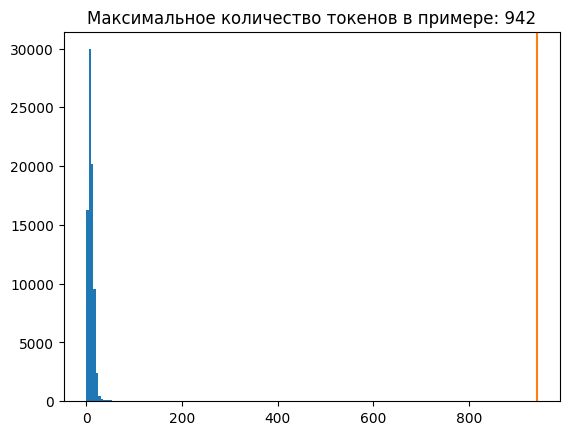

In [ ]:
# @title Отобразим график
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Максимальное количество токенов в примере: {max_length}');



In [ ]:
# Максимальная длина фразы
MAX_TOKENS=72

In [ ]:
# @title Добавление токенов
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

In [ ]:
words = answer_tokenizer.detokenize(add_start_end(token_batch))
tf.strings.reduce_join(words, separator=' ', axis=-1)

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'[START] \xd1\x82\xd0\xb0\xd0\xbc \xd1\x85\xd0\xbe\xd0\xbb\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe [END]',
       b'[START] \xd0\xb5\xd1\x81\xd0\xbb\xd0\xb8 \xd0\xb5\xd1\x81\xd1\x82\xd1\x8c \xd0\xbd\xd0\xb5\xd0\xbe\xd0\xb1\xd1\x85\xd0\xbe\xd0\xb4\xd0\xb8\xd0\xbc\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c , \xd1\x82\xd0\xbe \xd0\xba\xd0\xbe\xd0\xbd\xd0\xb5\xd1\x87\xd0\xbd\xd0\xbe \xd0\xb7\xd0\xb0\xd1\x81\xd0\xb5\xd0\xb4\xd0\xb0\xd0\xbd\xd0\xb8\xd0\xb5 \xd0\xbc\xd0\xbe\xd0\xb6\xd0\xb5\xd1\x82 \xd0\xb1\xd1\x8b\xd1\x82\xd1\x8c \xd0\xbe\xd1\x82\xd0\xbb\xd0\xbe\xd0\xb6\xd0\xb5\xd0\xbd\xd0\xbe . [END]',
       b'[START] \xd1\x87\xd0\xb0\xd0\xb1\xd0\xb0\xd0\xbd\xd1\x8b \xd0\xba\xd0\xb0\xd0\xb6\xd0\xb4\xd1\x83\xd1\x8e \xd0\xbe\xd0\xb2\xd1\x86\xd1\x83 \xd0\xb7\xd0\xbd\xd0\xb0\xd1\x8e\xd1\x82 \xd0\xb2 \xd0\xbb\xd0\xb8\xd1\x86\xd0\xbe . \xd1\x82 . \xd0\xb5 . \xd0\xb2 \xd0\xbc\xd0\xbe\xd1\x80\xd0\xb4\xd1\x83 . \xd0\xb0 \xd0\xb2\xd1\x8b \xd0\xb3\xd0\xbe\xd0\xb2\xd0\

In [ ]:
def cleanup_text(reserved_tokens, token_txt):
  # Удаление токенов, кроме "[UNK]".
  # Поиск зарезервированных токенов кроме [UNK]
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  # "Плохие" токены для регулярки объединяем знаком ИЛИ (|)
  bad_token_re = "|".join(bad_tokens)

  # Ищем в строке регулярку
  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  # Отсеиваем из исходной строки все найденные включения "плохих" токенов
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Сцепление строк.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

In [ ]:
print('Отберем строки для примера:')
for pt_examples, en_examples in train_dataset.batch(3).take(1):
  for ex in en_examples:
    print(ex.numpy())

Отберем строки для примера:
b'\xd1\x82\xd0\xb0\xd0\xbc \xd1\x85\xd0\xbe\xd0\xbb\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe'
b'\xd0\xb5\xd1\x81\xd0\xbb\xd0\xb8 \xd0\xb5\xd1\x81\xd1\x82\xd1\x8c \xd0\xbd\xd0\xb5\xd0\xbe\xd0\xb1\xd1\x85\xd0\xbe\xd0\xb4\xd0\xb8\xd0\xbc\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c, \xd1\x82\xd0\xbe \xd0\xba\xd0\xbe\xd0\xbd\xd0\xb5\xd1\x87\xd0\xbd\xd0\xbe \xd0\xb7\xd0\xb0\xd1\x81\xd0\xb5\xd0\xb4\xd0\xb0\xd0\xbd\xd0\xb8\xd0\xb5 \xd0\xbc\xd0\xbe\xd0\xb6\xd0\xb5\xd1\x82 \xd0\xb1\xd1\x8b\xd1\x82\xd1\x8c \xd0\xbe\xd1\x82\xd0\xbb\xd0\xbe\xd0\xb6\xd0\xb5\xd0\xbd\xd0\xbe.'
b'\xd1\x87\xd0\xb0\xd0\xb1\xd0\xb0\xd0\xbd\xd1\x8b \xd0\xba\xd0\xb0\xd0\xb6\xd0\xb4\xd1\x83\xd1\x8e \xd0\xbe\xd0\xb2\xd1\x86\xd1\x83 \xd0\xb7\xd0\xbd\xd0\xb0\xd1\x8e\xd1\x82 \xd0\xb2 \xd0\xbb\xd0\xb8\xd1\x86\xd0\xbe. \xd1\x82. \xd0\xb5. \xd0\xb2 \xd0\xbc\xd0\xbe\xd1\x80\xd0\xb4\xd1\x83. \xd0\xb0 \xd0\xb2\xd1\x8b \xd0\xb3\xd0\xbe\xd0\xb2\xd0\xbe\xd1\x80\xd0\xb8\xd1\x82\xd0\xb5 \xd0\xb2 \xd0\xbe\xd1\x82\xd0\xbb\xd0\xb8\xd1\

In [ ]:
en_examples.numpy()

array([b'\xd1\x82\xd0\xb0\xd0\xbc \xd1\x85\xd0\xbe\xd0\xbb\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe',
       b'\xd0\xb5\xd1\x81\xd0\xbb\xd0\xb8 \xd0\xb5\xd1\x81\xd1\x82\xd1\x8c \xd0\xbd\xd0\xb5\xd0\xbe\xd0\xb1\xd1\x85\xd0\xbe\xd0\xb4\xd0\xb8\xd0\xbc\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c, \xd1\x82\xd0\xbe \xd0\xba\xd0\xbe\xd0\xbd\xd0\xb5\xd1\x87\xd0\xbd\xd0\xbe \xd0\xb7\xd0\xb0\xd1\x81\xd0\xb5\xd0\xb4\xd0\xb0\xd0\xbd\xd0\xb8\xd0\xb5 \xd0\xbc\xd0\xbe\xd0\xb6\xd0\xb5\xd1\x82 \xd0\xb1\xd1\x8b\xd1\x82\xd1\x8c \xd0\xbe\xd1\x82\xd0\xbb\xd0\xbe\xd0\xb6\xd0\xb5\xd0\xbd\xd0\xbe.',
       b'\xd1\x87\xd0\xb0\xd0\xb1\xd0\xb0\xd0\xbd\xd1\x8b \xd0\xba\xd0\xb0\xd0\xb6\xd0\xb4\xd1\x83\xd1\x8e \xd0\xbe\xd0\xb2\xd1\x86\xd1\x83 \xd0\xb7\xd0\xbd\xd0\xb0\xd1\x8e\xd1\x82 \xd0\xb2 \xd0\xbb\xd0\xb8\xd1\x86\xd0\xbe. \xd1\x82. \xd0\xb5. \xd0\xb2 \xd0\xbc\xd0\xbe\xd1\x80\xd0\xb4\xd1\x83. \xd0\xb0 \xd0\xb2\xd1\x8b \xd0\xb3\xd0\xbe\xd0\xb2\xd0\xbe\xd1\x80\xd0\xb8\xd1\x82\xd0\xb5 \xd0\xb2 \xd0\xbe\xd1\x82\xd0\xbb\xd0\xb8\xd1\x87\x

In [ ]:
# @title Детокенизированные строки
token_batch = answer_tokenizer.tokenize(en_examples).merge_dims(-2,-1)
words = answer_tokenizer.detokenize(token_batch)
words

<tf.RaggedTensor [[b'\xd1\x82\xd0\xb0\xd0\xbc',
  b'\xd1\x85\xd0\xbe\xd0\xbb\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe'],
 [b'\xd0\xb5\xd1\x81\xd0\xbb\xd0\xb8', b'\xd0\xb5\xd1\x81\xd1\x82\xd1\x8c',
  b'\xd0\xbd\xd0\xb5\xd0\xbe\xd0\xb1\xd1\x85\xd0\xbe\xd0\xb4\xd0\xb8\xd0\xbc\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c',
  b',', b'\xd1\x82\xd0\xbe',
  b'\xd0\xba\xd0\xbe\xd0\xbd\xd0\xb5\xd1\x87\xd0\xbd\xd0\xbe',
  b'\xd0\xb7\xd0\xb0\xd1\x81\xd0\xb5\xd0\xb4\xd0\xb0\xd0\xbd\xd0\xb8\xd0\xb5',
  b'\xd0\xbc\xd0\xbe\xd0\xb6\xd0\xb5\xd1\x82',
  b'\xd0\xb1\xd1\x8b\xd1\x82\xd1\x8c',
  b'\xd0\xbe\xd1\x82\xd0\xbb\xd0\xbe\xd0\xb6\xd0\xb5\xd0\xbd\xd0\xbe', b'.']                                  ,
 [b'\xd1\x87\xd0\xb0\xd0\xb1\xd0\xb0\xd0\xbd\xd1\x8b',
  b'\xd0\xba\xd0\xb0\xd0\xb6\xd0\xb4\xd1\x83\xd1\x8e',
  b'\xd0\xbe\xd0\xb2\xd1\x86\xd1\x83',
  b'\xd0\xb7\xd0\xbd\xd0\xb0\xd1\x8e\xd1\x82', b'\xd0\xb2',
  b'\xd0\xbb\xd0\xb8\xd1\x86\xd0\xbe', b'.', b'\xd1\x82', b'.', b'\xd0\xb5',
  b'.', b'\xd0\xb2', b'\xd0\xbc\xd0\xbe\xd1\x8

# Кастомный Токенизатор

In [ ]:
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    # Определяем токенизатор
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    # Зарезервированные токены
    self._reserved_tokens = reserved_tokens
    # Путь к файлу словаря
    self._vocab_path = tf.saved_model.Asset(vocab_path)
    # Читаем из файла словарь и делим по строкам
    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    # Сигнатура для tokenize (работает с пакетами строк).
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()


  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Объединяем оси `word` и `word-piece`
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words) # очищаем перед выводом

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids) # возвращаем явное соответствие словаря токенам

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0] # определяем длину словаря по нулевому индексу формы

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path # получение пути к файлу словаря

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens) # получение списка зарезервированных токенов

In [ ]:
tokenizers = tf.Module()
tokenizers.pt = CustomTokenizer(reserved_tokens, 'question_vocab.txt')
tokenizers.en = CustomTokenizer(reserved_tokens, 'answer_vocab.txt')

In [ ]:
model_name = 'ted_hrlr_translate_quest_ans_converter'
tf.saved_model.save(tokenizers, model_name)

In [ ]:
# @title Пример токенизации
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 114, 2469, 3]
[2, 75, 85, 2706, 5, 72, 132, 98, 835, 2747, 109, 119, 86, 414, 5458, 7, 3]
[2, 59, 84, 783, 210, 3664, 50, 200, 1114, 753, 39, 1365, 7, 54, 7, 42, 7, 39, 48, 642, 448, 7, 37, 110, 2193, 39, 3215, 3]


In [ ]:
# @title Пример детокенизации
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

там холодно
если есть необходимость , то конечно заседание может быть отложено .
чабаны каждую овцу знают в лицо . т . е . в морду . а вы говорите в отличие


In [ ]:
# @title Преобразование идентификаторов токенов в текстовое представление токенов
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'\xd1\x82\xd0\xb0\xd0\xbc',
  b'\xd1\x85\xd0\xbe\xd0\xbb\xd0\xbe\xd0\xb4\xd0\xbd\xd0\xbe', b'[END]'],
 [b'[START]', b'\xd0\xb5\xd1\x81\xd0\xbb\xd0\xb8',
  b'\xd0\xb5\xd1\x81\xd1\x82\xd1\x8c',
  b'\xd0\xbd\xd0\xb5\xd0\xbe\xd0\xb1\xd1\x85\xd0\xbe\xd0\xb4\xd0\xb8\xd0\xbc\xd0\xbe\xd1\x81\xd1\x82\xd1\x8c',
  b',', b'\xd1\x82\xd0\xbe',
  b'\xd0\xba\xd0\xbe\xd0\xbd\xd0\xb5\xd1\x87\xd0\xbd\xd0\xbe',
  b'\xd0\xb7\xd0\xb0', b'##\xd1\x81\xd0\xb5',
  b'##\xd0\xb4\xd0\xb0\xd0\xbd\xd0\xb8\xd0\xb5',
  b'\xd0\xbc\xd0\xbe\xd0\xb6\xd0\xb5\xd1\x82',
  b'\xd0\xb1\xd1\x8b\xd1\x82\xd1\x8c', b'\xd0\xbe\xd1\x82',
  b'##\xd0\xbb\xd0\xbe', b'##\xd0\xb6\xd0\xb5\xd0\xbd\xd0\xbe', b'.',
  b'[END]']                                                                                                   ,
 [b'[START]', b'\xd1\x87', b'##\xd0\xb0', b'##\xd0\xb1\xd0\xb0',
  b'##\xd0\xbd\xd1\x8b',
  b'\xd0\xba\xd0\xb0\xd0\xb6\xd0\xb4\xd1\x83\xd1\x8e', b'\xd0\xbe',
  b'##\xd0\xb2', b'##\xd1\x86\x

# Подготовка датасета, предобработка данных

In [ ]:
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)   # Токенизируем данные
    pt = pt[:, :MAX_TOKENS]           # Выравнивание данных по MAX_TOKENS.
    pt = pt.to_tensor()               # Преобразуем в тензор с равномерными измерениями

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Удаляем [END] токены (вход декодировщика)
    en_labels = en[:, 1:].to_tensor()   # Удаляем [START] токены (выход декодировщика)

    return (pt, en_inputs), en_labels

In [ ]:
# Размер буфера в памяти при подготовке датасета
BUFFER_SIZE = 20000

# Размер пакета
BATCH_SIZE = 64

In [ ]:
# @title Прогоним фразы через подготовленную функцию и сформируем пакеты
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)                     # перемешиваем данные
      .batch(BATCH_SIZE)                        # делим датасет на пакеты
      .map(prepare_batch, tf.data.AUTOTUNE)     # применим функцию prepare_batch
      .prefetch(buffer_size=tf.data.AUTOTUNE))  # prefetch используется для разделения времени, когда данные подготавливаются и потребляются, что ускоряет обучение сети

In [ ]:
train_batches = make_batches(train_dataset)
val_batches = make_batches(validation_dataset)

In [ ]:
# @title Вывод формы одного пакета
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 33)
(64, 44)
(64, 44)


# Архитектура модели

In [ ]:
# @title Функция позиционного кодирования

# length - порядковый номер слова в фразе
# depth - размер пространства эмбеддинга
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # форма (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # форма (1, depth)

  angle_rates = 1 / (10000**depths)         # форма (1, depth)
  angle_rads = positions * angle_rates      # форма (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)  # указываем тип возвращаемых данных

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)

# Прверим форму
print(pos_encoding.shape)


(2048, 512)


In [ ]:
# @title Создание слоя PositionalEmbedding
# Наследуем класс от tf.keras.layers.Layer
# Теперь наш слой тоже является классом Keras
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) # эмбеддинг
    self.pos_encoding = positional_encoding(length=2048, depth=d_model) # позиционное кодирование

  # Данный метод возвращает маску эмбеддинга
  # Так как вектора выравниваются до одной длины с помощью pad_sequences,
  # то метод вернет True для ненулевых токенов, и False для нулевых токенов

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)

    # Этот коэффициент задает относительный масштаб встраивания и позиционного кодирования
    # C этим параметром можно и нужно играться!
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [ ]:
# Проверка слоя
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size().numpy(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size().numpy(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

# Выводим маску
en_emb._keras_mask

<tf.Tensor: shape=(64, 44), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

# Слой нормализации и остаточной связи

## Базовый класс внимания

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

# Encoder-Decoder Attention

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    # Пропускаем сигнал через многоголовое внимание
    attn_output, attn_scores = self.mha(
        query=x,                        # запрос
        key=context,                    # ключ
        value=context,                  # значение
        return_attention_scores=True)   # возвращаем оценки внимания

    # Запоминаем оценки на будущее
    self.last_attn_scores = attn_scores

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
# @title Пример прохождения сигнала через слой
# При инициализации через базовый класс передаем в слой tf.keras.layers.MultiHeadAttention
# параметры num_heads - число голов, key_dim - размерность ключа
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 33, 512)
(64, 44, 512)
(64, 44, 512)


## Слой GlobalSelfAttention

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    # Пропускаем сигнал через многоголовое внимание
    attn_output = self.mha(
        query=x,  # запрос
        value=x,  # ключ
        key=x)    # значение

    # Добавляем остаточную связь и нормализацию
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 33, 512)
(64, 33, 512)


# Слой CausalSelfAttention

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)  # отличается от GlobalSelfAttention одним аргументом
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 44, 512)
(64, 44, 512)


# Сеть прямого распространения (feed forward network)

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 44, 512)
(64, 44, 512)


# Слой Кодировщика

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,  # число голов
        key_dim=d_model,      # размерность ключа
        dropout=dropout_rate) # уровень регуляризации

    self.ffn = FeedForward(d_model, dff) # число нейронов во втором и первом Dense слое, соответственно

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 33, 512)
(64, 33, 512)


# Блок Кодировщика

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    # Инициируем переменные внутри класса
    self.d_model = d_model
    self.num_layers = num_layers

    # Создаем объект класса позиционного кодирования
    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    # Создаем объект класса для слоя кодировщика
    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Создаем объект класса для слоя регуляризации
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # Форма x токена: (batch, seq_len)
    # Прогоняем последовательность токенов через слой позиционного кодирования
    x = self.pos_embedding(x)  # форма на выходе (batch_size, seq_len, d_model)

    # Прогоняем последовательность токенов через слой регуляризации
    x = self.dropout(x)

    # Прогоняем последовательность токенов через num_layers слоев кодировщика
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # форма на выходе (batch_size, seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(pt, training=False)

print(pt.shape)
print(sample_encoder_output.shape)  # форма на выходе (batch_size, input_seq_len, d_model)

(64, 33)
(64, 33, 512)


# Слой декодировщика

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    # Слой внимания с причинно-следственной связью
    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # Слой с кросс-вниманием
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    # Слой прямого распространения
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    # Пропускаем последовательность токенов через:
    # Каузальный слой внимания
    x = self.causal_self_attention(x=x)
    # Слой кросс-внимания и контекстным вектором из кодировщика
    x = self.cross_attention(x=x, context=context)

    # Запомним оценки внимания на будущее
    self.last_attn_scores = self.cross_attention.last_attn_scores
    # Через слой прямого распространения
    x = self.ffn(x)  # Форма `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # Форма `(batch_size, seq_len, d_model)`

(64, 44, 512)
(64, 33, 512)
(64, 44, 512)


# Блок Декодировщика

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    # Инициируем переменные внутри класса
    self.d_model = d_model
    self.num_layers = num_layers

    # Создаем объект класса позиционного кодирования
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    # Создаем объект класса для слоя регуляризации
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

    # Создаем сразу стек слоев декодировщиков с помощью генератора списков по числу слоев
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    # Сбрасываем оценки внимания
    self.last_attn_scores = None

  def call(self, x, context):
    # Подаем на вход последовательность токенов x формой (batch, target_seq_len)

    # Пропускаем через слой позиционного кодирования (и конечно же эмбеддинг)
    x = self.pos_embedding(x)  # форма на выходе (batch_size, target_seq_len, d_model)

    # Регуляризация
    x = self.dropout(x)

    # Прогоняем через num_layers слоев декодировщиков
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    # Сохраняем оценки внимания из последнего слоя
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # Форма x на выходе (batch_size, target_seq_len, d_model)
    return x

In [ ]:
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 44)
(64, 33, 512)
(64, 44, 512)


# Трансформер

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    # Кодировщик
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)
    # Декодировщик
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
    # Конечный слой
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # Чтобы использовать метод `.fit` для обучения модели, необходимо передать
    # все входные данные в первом аргументе
    context, x  = inputs

    # Передаем контекст в кодировщик
    context = self.encoder(context)  # форма выходных данных (batch_size, context_len, d_model)

    # Передаем контекст и целевой вектор в декодировщик
    x = self.decoder(x, context)  # форма выходных данных (batch_size, target_len, d_model)

    # Прогоняем выходные данные через финальный слой
    logits = self.final_layer(x)  # форма выходных данных (batch_size, target_len, target_vocab_size)

    try:
      # После прохождения данных через все слои необходимо удалить
      # маску, чтобы она не масштабировала, потери и метрики
      # Обработчик ошибок позволяет избежать исключений при повторной попытке удаления
      del logits._keras_mask
    except AttributeError: # отлавливаем ошибку отсутствия аттрибута
      pass

    # Возвращаем наши логиты
    return logits

# Обучение

## Параметры для обучения

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

EPOCHS = 10

## Собираем трансформер

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

# Оценки внимания
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # Форма оценок внимания: (batch, heads, target_seq, input_seq)

(64, 44)
(64, 33)
(64, 44, 6806)
(64, 8, 44, 33)


## Оптимизатор

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
# Количество батчей для обучения
num_batches = 0
for (batch, (_,_)) in enumerate(train_batches):
  num_batches = batch
print(num_batches)

624


Text(0.5, 0, 'Шаг обучения')

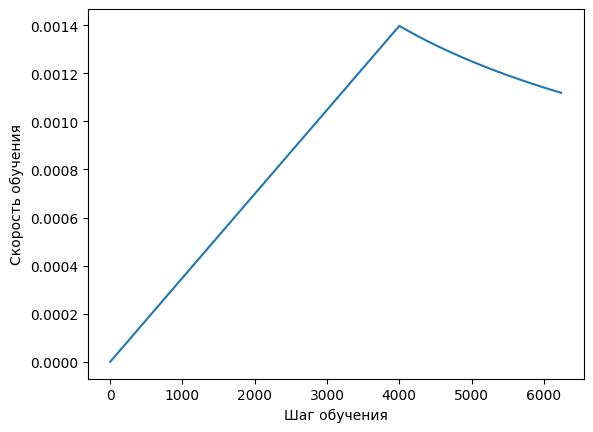

In [ ]:
# @title Скорость обучения при 10 эпохах
plt.plot(learning_rate(tf.range(num_batches*EPOCHS, dtype=tf.float32)))
plt.ylabel('Скорость обучения')
plt.xlabel('Шаг обучения')

Text(0.5, 0, 'Шаг обучения')

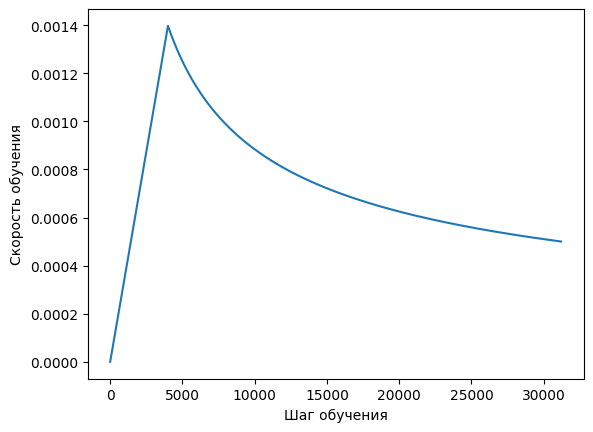

In [ ]:
# @title Скорость обучения при 50 эпохах
plt.plot(learning_rate(tf.range(num_batches*EPOCHS*5, dtype=tf.float32)))
plt.ylabel('Скорость обучения')
plt.xlabel('Шаг обучения')

## Функция потерь и метрики

In [ ]:
# Функция потерь с учетом маски
def masked_loss(label, pred):
  # Задаем маску, где метки не равны 0
  mask = label != 0
  # Определяем функцию потерь
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  # Важно чтобы mask и loss имели одинаковый тип данных
  mask = tf.cast(mask, dtype=loss.dtype)
  # Наложение маски на loss
  loss *= mask

  # Масштабирование потерь на маску
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

# Функция точности с учетом маски
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  # Оценка совпадения метки и предсказания
  match = label == pred
  # Задаем маску, где метки не равны 0
  mask = label != 0

  # Логическое И
  match = match & mask

  # Преобразуем к одному типу и масштабирование совпадений на маску
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Компилируем и обучаем модель

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 959s 1s/step - loss: 8.1082 - masked_accuracy: 0.0496 - val_loss: 6.3098 - val_masked_accuracy: 0.0995
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 929s 1s/step - loss: 6.1335 - masked_accuracy: 0.1104 - val_loss: 5.7141 - val_masked_accuracy: 0.1202
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 935s 1s/step - loss: 5.5971 - masked_accuracy: 0.1305 - val_loss: 5.4375 - val_masked_accuracy: 0.1282
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 935s 1s/step - loss: 5.2896 - masked_accuracy: 0.1412 - val_loss: 5.2647 - val_masked_accuracy: 0.1396
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 932s 1s/step - loss: 5.0623 - masked_accuracy: 0.1521 - val_loss: 5.1717 - val_masked_accuracy: 0.1458
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 931s 1s/step - loss: 4.8630 - masked_accuracy: 0.1661 - val_loss: 5.1276 - val_masked_accuracy: 0.1469
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 940s 2s/step - loss: 4.7433 - masked_accuracy: 0.1712 - val_loss: 5.0860 - val_masked_accuracy: 0.1550

# Тестирование модели

## Класс переводчика

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):

    assert isinstance(sentence, tf.Tensor) # Проверяем, что последовательность является тензором
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    # Введенное предложение написано на португальском языке
    encoder_input = sentence

    # Поскольку языком вывода является английский, инициализируйте вывод с помощью токена [START]
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # Здесь требуется  tf.TensorArray` (вместо списка Python), чтобы динамический цикл
    # можно было отследить с помощью `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      # на каждом шаге складываем выходные токены в массив для
      #  передачи на вход на следующем шаге
      output = tf.transpose(output_array.stack())
      # передаем в трансформер для предсказания токены
      predictions = self.transformer([encoder_input, output], training=False)

      # Выбираем последний токен из измерения `seq_len`
      predictions = predictions[:, -1:, :]  # Форма `(batch_size, 1, vocab_size)`.

      # Предсказанный токен
      predicted_id = tf.argmax(predictions, axis=-1)

      # Объединяем `predicted_id` с выходными данными, которые передаются
      # декодеру в качестве входных данных.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # Токены в текст
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` не позволяет нам использовать значения attention_weight, которые были
    # рассчитаны на последней итерации цикла.
    # Поэтому пересчитаем их вне цикла.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Фраза для перевода:":25s}: {sentence}')
  print(f'{"Предсказанный перевод:":25s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Оригинальный перевод":25s}: {ground_truth}')

## Пример № 1

In [ ]:
sentence = 'сделай ауе.'
ground_truth = 'забанят сразу'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Фраза для перевода:      : сделай ауе.
Предсказанный перевод:   : я не знаю
Оригинальный перевод     : забанят сразу


## Пример № 2

In [ ]:
sentence = 'а как можно за мужчиной виртуально поухаживать?'
ground_truth = 'сначала застолби его, чтобы другие тети не претендовали'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Фраза для перевода:      : а как можно за мужчиной виртуально поухаживать?
Предсказанный перевод:   : я не люблю , а я не люблю .
Оригинальный перевод     : сначала застолби его, чтобы другие тети не претендовали


## Пример № 3

In [ ]:
sentence = 'а бывают ли такие случаи когда ученицы за хорошую оценку делают учителю минет или трахаются с ним?'
ground_truth = "бывают я ректор."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Фраза для перевода:      : а бывают ли такие случаи когда ученицы за хорошую оценку делают учителю минет или трахаются с ним?
Предсказанный перевод:   : я не люблю , а я люблю .
Оригинальный перевод     : бывают я ректор.
